<a href="https://colab.research.google.com/github/hardik1408/MADHAV-LABS/blob/main/task4_image_inpainting_partial_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Inpainting using Partial Convolutions
- I have implemented Image Inpainting using Partial Convolution.
- Implementation has been done in Keras.



Brief description of model:

Partial Convolutional U-Net model with methods for building the model, compiling, and defining various loss functions. The class includes methods for training the model using a generator and making predictions. The model utilizes VGG16 for perceptual and style losses and includes custom loss functions such as hole loss, valid loss, and total variation loss. The generator function is used for training the model with a generator.

# **Installing and Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
import itertools

# **Loading the dataset**

In [2]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cuda:0


In [3]:
# Normalization and tensor conversion for both training and testing datasets using PyTorch's transforms
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
# downloading the dataset
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform_test)

100%|██████████| 170498071/170498071 [00:02<00:00, 78881055.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [7]:
# Fetching a batch of images and labels from a PyTorch DataLoader for training.
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [11]:
img = images[0]
npimg = img.numpy()
npimg = np.transpose(npimg, (1,2,0))

In [8]:
batch_size = 4

In [9]:
# Function to display images
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize = (batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

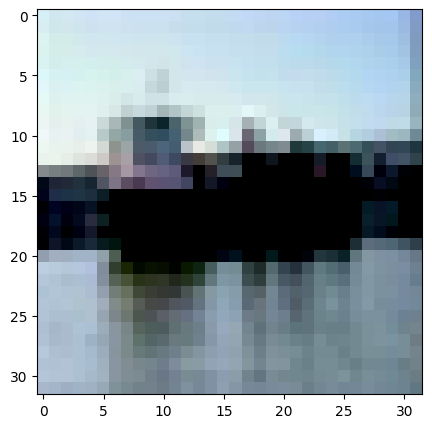

In [42]:
plt.figure(figsize = (5,5))
plt.imshow(npimg)
plt.show()

In [45]:
# function to show images in batches
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = "example images")

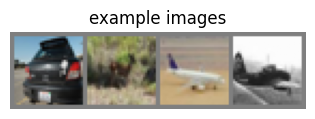

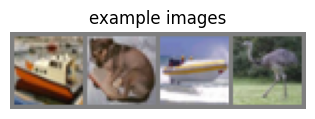

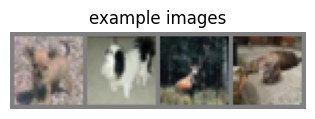

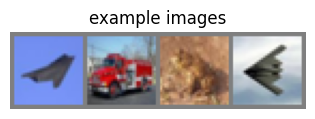

In [46]:
for i in range(4):
  show_batch_images(trainloader)

# **Defining variuous classes**

In [ ]:
# Custom PyTorch dataset class for CIFAR-10 images with an additional method to create masked images, generating random lines as masks.
# The dataset returns input, mask, and output images for training.

class Dataset(torchvision.datasets.CIFAR10):
  def __init__(self, path, image_dims = (32, 32), n_channels = 3, train = True):
    super().__init__(path, train, download = True)
    self.n_classes = 10
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(1, 3)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [ ]:
# A class MaskGenerator that creates masks with random lines, circles, ellipses, or rectangles on an image for data augmentation, with parameters like scale ratio and shape randomness.
class MaskGenerator():

    def __init__ (self,X=None,scale_ratio = 0.03) :

        self.height, self.width , self.channels = X.shape
        self.mask = np.zeros((self.height,self.width,self.channels),dtype='uint8')
        self.scale_ratio = scale_ratio
        self.masker()


    def masker(self,line=True,circle=True,ellipse=True,rectangle=False,polygon=False) :

        scale = int((self.height+self.width)*self.scale_ratio)
        if line :
            for i in range(randint(1,15)):
                x1,x2 = randint(1,self.width) ,randint(1,self.width)
                y1,y2 = randint(1,self.height) ,randint(1,self.height)
                cv2.line(self.mask,(x1,x2),(y1,y2),(1,1,1),randint(4,scale))
        if circle :
            for i in range(randint(1,15)):
                cx,cy  = randint(1,self.width), randint(1,self.height)
                radius = randint(30,50)
                cv2.circle(self.mask, (cx,cy), radius, (1,1,1), randint(4,scale))
        if ellipse :
            for i in range(randint(1,15)):
                x1, y1 = randint(1, self.width), randint(1, self.height)
                s1, s2 = randint(1, self.width), randint(1, self.height)
                a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
                thickness = randint(20, scale)
                cv2.ellipse(self.mask, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)

        if rectangle :
             for i in range(randint(1,15)):
                x1,x2 = randint(1,self.width) ,randint(1,self.width)
                y1,y2 = randint(1,self.height) ,randint(1,self.height)
                cv2.rectangle(self.mask, (x1,y1), (x2,y2), (1,1,1), randint(4,20))

        self.mask = 1 - self.mask

In [ ]:

class PConvUNET(object):

    def __init__(self,h,w,c,data_format='channels_last',weights='imagenet'):

        self.h = h
        self.w = w
        self.c = c
        self.data_format = data_format
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.no_of_pixels = h*w*c
        self.vgg_layers=[3,6,10]
        self.vgg = self.vgg_model(weights)
        self.model,self.masks = self.build_pconv_UNet()
        self.model_compile(self.model,self.masks)


    def vgg_model(self,weights):
        '''A non-trainable vgg-model trained on imagenet
           is used to extract features from higher level
           layers namely : pool1,pool2,pool3 which will be
           used for calculating perceptual and style losses'''
        if weights == 'imagenet' :
            vgg = VGG16(include_top=False,weights='imagenet')
        else :
            vgg = VGG16(weights=None, include_top=False)
            vgg.load_weights(weights, by_name=True)
        imgs = Input((self.h,self.w,self.c))
        processed = Lambda(lambda x: (x-self.mean) / self.std)(imgs)
        vgg.outputs = [vgg.layers[i].output for i in self.vgg_layers]
        model = Model(inputs=imgs,outputs=vgg(processed))
        model.trainable = False
        model.compile(loss='mse',optimizer='adam')
        return model

    def build_pconv_UNet(self,train_bn=True):

        inputs_img = Input((self.h, self.w, 3), name='inputs_img')
        inputs_mask = Input((self.h, self.w, 3), name='inputs_mask')

        def encoder_layer(imgs,masks,filters,kernel_size,bn=True):
            I_out , Mask_out = Pconv(filters,kernel_size,strides=2,padding='same')([imgs,masks])
            if bn :
                I_out = BatchNormalization()(I_out,training=train_bn)
            I_out = Activation('relu')(I_out)

            return I_out,Mask_out

        en_img1, en_mask1 = encoder_layer(inputs_img,inputs_mask,64,7,False)
        en_img2, en_mask2 = encoder_layer(en_img1,en_mask1,128,5)
        en_img3, en_mask3 = encoder_layer(en_img2,en_mask2,256,5)
        en_img3, en_mask3 = encoder_layer(en_img2,en_mask2,256,5)
        en_img3, en_mask3 = encoder_layer(en_img2,en_mask2,256,5)
        en_img4, en_mask4 = encoder_layer(en_img3,en_mask3,512,3)
        en_img5, en_mask5 = encoder_layer(en_img4,en_mask4,512,3)
        en_img6, en_mask6 = encoder_layer(en_img5,en_mask5,512,3)
        en_img7, en_mask7 = encoder_layer(en_img6,en_mask6,512,3)
        en_img8, en_mask8 = encoder_layer(en_img7,en_mask7,512,3)


        def decoder_layer(imgs,masks,en_img,en_mask,filters,kernel_size,bn=True,**kwargs):
            I_up    = UpSampling2D(size=(2,2),data_format=self.data_format)(imgs)
            mask_up = UpSampling2D(size=(2,2),data_format=self.data_format)(masks)
            if self.data_format == 'channels_first' :
                axis = 1
            else :
                axis = 3

            I_up_concat    = Concatenate(axis)([I_up,en_img])
            mask_up_concat = Concatenate(axis)([mask_up,en_mask])

            I_out, Mask_out = Pconv(filters,kernel_size,padding='same')([I_up,mask_up])
            if bn:
                I_out = BatchNormalization()(I_out)
            I_out = LeakyReLU(alpha=0.2)(I_out)
            return I_out, Mask_out

        dec_conv1, dec_mask1 = decoder_layer(en_img8,en_mask8,en_img7,en_mask7,512,3)
        dec_conv2, dec_mask2 = decoder_layer(dec_conv1,dec_mask1,en_img6,en_mask6,512,3)
        dec_conv3, dec_mask3 = decoder_layer(dec_conv2,dec_mask2,en_img5,en_mask5,512,3)
        dec_conv4, dec_mask4 = decoder_layer(dec_conv3,dec_mask3,en_img4,en_mask4,512,3)
        dec_conv5, dec_mask5 = decoder_layer(dec_conv4,dec_mask4,en_img3,en_mask3,256,3)
        dec_conv6, dec_mask6 = decoder_layer(dec_conv5,dec_mask5,en_img2,en_mask2,128,3)
        dec_conv7, dec_mask7 = decoder_layer(dec_conv6,dec_mask6,en_img1,en_mask1,64,3)
        dec_conv8, dec_mask8 = decoder_layer(dec_conv7,dec_mask7,inputs_img,inputs_mask,3,3,bn=False)

        outputs = Conv2D(3, 1, activation = 'sigmoid', name='outputs_img')(dec_conv8)
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask


    def model_compile(self,model,masks,lr=0.001):
        model.compile(
                     loss=self.loss_total(masks),
                     optimizer= Adam(lr=lr),
                     metrics=[self.PSNR]
                     )


    def loss_total(self,M):

        def loss(I_out,I_gt):
            '''I_comp is obtained by setting all the non hole pixels of I_out directly to ground truth'''
            I_comp   = I_out*(1-M) + I_gt*M
            vgg_out  = self.vgg(I_out)
            vgg_comp = self.vgg(I_comp)
            vgg_gt   = self.vgg(I_gt)

            l1 = self.hole_loss(I_out,I_gt,M)
            l2 = self.loss_valid(I_out,I_gt,M)
            l3 = self.loss_perceptual(vgg_out,vgg_gt,vgg_comp)
            l4 = self.style_loss(vgg_out,vgg_gt)
            l5 = self.style_loss(vgg_comp,vgg_gt)
            l6 = self.loss_tv(M,I_comp)

            return l1 + 6*l2 + 0.05*l3 + 120*(l4+l5) + 0.1*l6
        return loss


    def hole_loss(self,I_out,I_gt,M):
        '''Per pixel loss defined as the L1 distance between the ground truth and the output image
           after multiplying by (1-M) where M is the corresponding mask'''
        return self.l1((1-M)*I_out,(1-M)*I_gt)

    def loss_valid(self,I_out,I_gt,M):
        ''' loss_valid = L1 distance of M * (I_out-I_gt)'''
        return self.l1(M*I_out,M*I_gt)

    def loss_perceptual(self,vgg_out,vgg_gt,vgg_comp):
        loss = 0
        for i,j,k in zip(vgg_out,vgg_comp,vgg_gt) :
            '''if K.ndim(i) == 4:
                _,n1,n2,n3 = K.shape(i)
            else :
                n1,n2,n3 = K.shape(i)
            n = n1*n2*n3'''
            loss += self.l1(i,k) + self.l1(j,k)
        return loss

    def style_loss(self,output,vgg_gt):
        loss = 0
        for o, g in zip(output, vgg_gt):
            loss += self.l1(self.gram_matrix(o), self.gram_matrix(g))
        return loss

    def loss_tv(self, mask, y_comp):
        """Total variation loss, used for smoothing the hole region, see. eq. 6"""

        # Create dilated hole region using a 3x3 kernel of all 1s.
        kernel = K.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
        dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

        # Cast values to be [0., 1.], and compute dilated hole region of y_comp
        dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
        P = dilated_mask * y_comp

        # Calculate total variation loss
        a = self.l1(P[:,1:,:,:], P[:,:-1,:,:])
        b = self.l1(P[:,:,1:,:], P[:,:,:-1,:])
        return a+b

    def model_summary(self):
        return self.model.summary()


    def generator(self,generator,*args,**kwargs):
        self.model.fit_generator(generator,*args,**kwargs)

    ##############################################################################
    '''Gram-matrix function taken from github.
       It is required for the style loss terms'''

    def gram_matrix(self,x, norm_by_channels=False):
        """Calculate gram matrix used in style loss"""

        # Assertions on input
        assert K.ndim(x) == 4, 'Input tensor should be a 4d (B, H, W, C) tensor'
        assert K.image_data_format() == 'channels_last', "Please use channels-last format"

        # Permute channels and get resulting shape
        x = K.permute_dimensions(x, (0, 3, 1, 2))
        shape = K.shape(x)
        B, C, H, W = shape[0], shape[1], shape[2], shape[3]

        # Reshape x and do batch dot product
        features = K.reshape(x, K.stack([B, C, H*W]))
        gram = K.batch_dot(features, features, axes=2)

        # Normalize with channels, height and width
        gram = gram /  K.cast(C * H * W, x.dtype)

        return gram
    ################################################################################################


    def l1(self,y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")

    def PSNR(self,y_true, y_pred):
        """
        PSNR is Peek Signal to Noise Ratio, see https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
        The equation is:
        PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)

        Our input is scaled with be within the range -2.11 to 2.64 (imagenet value scaling). We use the difference between these
        two values (4.75) as MAX_I
        """
        #return 20 * K.log(4.75) / K.log(10.0) - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0)
        return - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0)


    def predict(self,test,**kwargs):
        return self.model.predict(test,**kwargs)

In [ ]:
class PartialConv(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()

        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)

        self.window_size = kernel_size[0] * kernel_size[1]

        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)

        mask_ratio = mask_ratio * output_mask

        output = output * mask_ratio

        output = output + output_bias

        return output, output_mask

In [ ]:
# a class defining functions for the encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [ ]:
# a class defining functions for the decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()

        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))

        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)
        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)

        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [ ]:
# a class defining functions for the inpainting module
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(32, 32), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        conv_out_9, mask_out_9, conv_out_10, mask_out_10 = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        conv_out_11, mask_out_11, conv_out_12, mask_out_12 = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        conv_out_13, mask_out_13, conv_out_14, mask_out_14 = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        conv_out_15, mask_out_15, conv_out_16, mask_out_16 = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs

# **Data Pre Proccessing**

In [16]:
image_dims = (32, 32)
batch_size = 4

In [17]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [19]:
Trainset = Dataset('./data', image_dims)
Testset = Dataset('./data', image_dims, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [21]:
Train_dataiter = iter(Trainloader)
Test_dataiter = iter(Testloader)

In [22]:
X_in, X_mask, Y_out = next(Train_dataiter)
print(X_in.shape, X_mask.shape, Y_out.shape)

torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 32, 32])


Masked Image


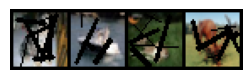

Masking Pattern


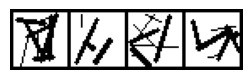

Original Image


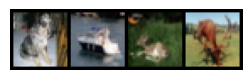

In [23]:
# printing example images
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Building the model**

In [28]:
#  computation of the Jaccard coefficient
def jaccard_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    union = (outputs.sum() + Y_output.sum()) - intersection
  return (intersection / (union + eps))

In [29]:
# defining the models
model = InpaintingModel()
model = model.to(device)

In [30]:
# defining the loss function and optimizer
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

Min loss 0.08
Iteration: 0/12500, Loss: 0.08
Min loss 0.07
Min loss 0.04
Min loss 0.03
Iteration: 100/12500, Loss: 0.08
Min loss 0.03
Min loss 0.03
Min loss 0.03
Min loss 0.03
Min loss 0.02
Min loss 0.02
Min loss 0.02
Min loss 0.01
Min loss 0.01
Iteration: 200/12500, Loss: 0.02
Min loss 0.01
Min loss 0.01
Min loss 0.01
Min loss 0.01
Min loss 0.01
Iteration: 300/12500, Loss: 0.01
Min loss 0.01
Min loss 0.01
Iteration: 400/12500, Loss: 0.01
Iteration: 500/12500, Loss: 0.01
Min loss 0.01
Min loss 0.00
Iteration: 600/12500, Loss: 0.01
Iteration: 700/12500, Loss: 0.01
Iteration: 800/12500, Loss: 0.01
Iteration: 900/12500, Loss: 0.01
Iteration: 1000/12500, Loss: 0.01
Iteration: 1100/12500, Loss: 0.01
Iteration: 1200/12500, Loss: 0.02
Iteration: 1300/12500, Loss: 0.02
Iteration: 1400/12500, Loss: 0.01
Iteration: 1500/12500, Loss: 0.02
Iteration: 1600/12500, Loss: 0.01
Iteration: 1700/12500, Loss: 0.01
Iteration: 1800/12500, Loss: 0.02
Iteration: 1900/12500, Loss: 0.02
Iteration: 2000/12500, L

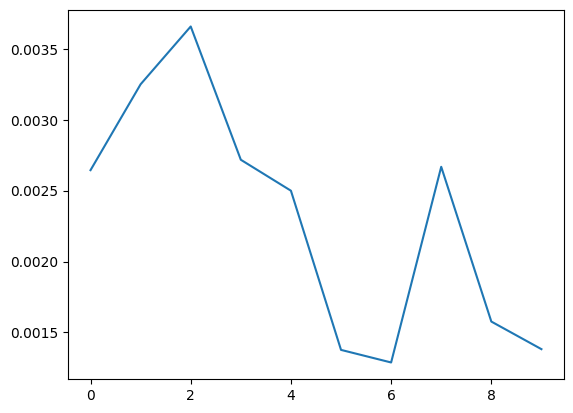

CPU times: user 22min 46s, sys: 1min 47s, total: 24min 34s
Wall time: 26min 4s


In [31]:
%%time
loss_epoch_arr = []
max_epochs = 10

min_loss = 1000

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
    model.train()
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()

        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)

        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.002f' % (i, n_iters, loss.item()))

        del X_input, X_mask, Y_output
        torch.cuda.empty_cache()

    loss_epoch_arr.append(loss.item())

plt.plot(loss_epoch_arr)
plt.show()

# **Performance of the model**

In [32]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [33]:
print(model)

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fals

In [34]:
weight_layer0 = list(model.parameters())[0].cpu()
weight_layer0 = weight_layer0.data.numpy()

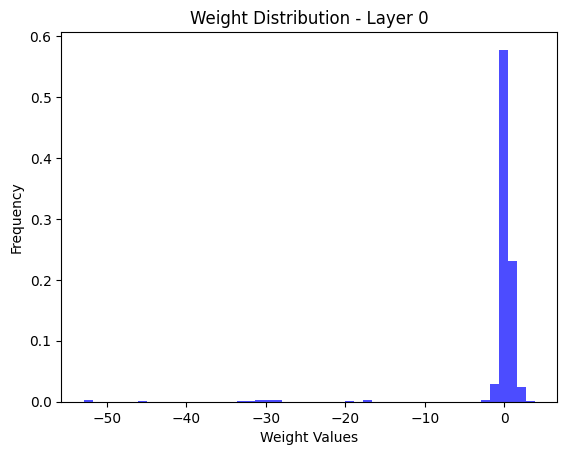

In [35]:
#histogram to show the distribution of values
plt.hist(weight_layer0.ravel(), bins=50, density=True, alpha=0.7, color='b')
plt.xlabel('Weight Values')
plt.ylabel('Frequency')
plt.title('Weight Distribution - Layer 0')
plt.show()

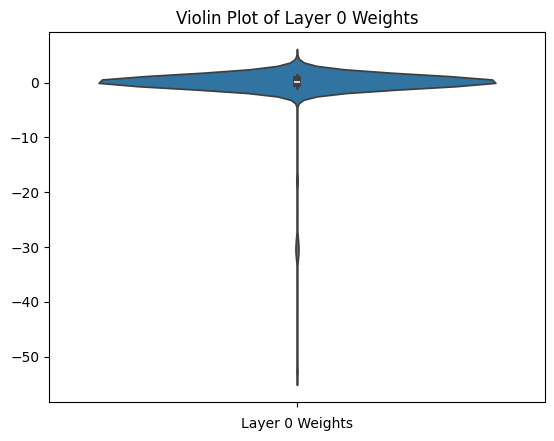

In [37]:
sns.violinplot(y=weight_layer0.ravel())
plt.xlabel('Layer 0 Weights')
plt.title('Violin Plot of Layer 0 Weights')
plt.show()

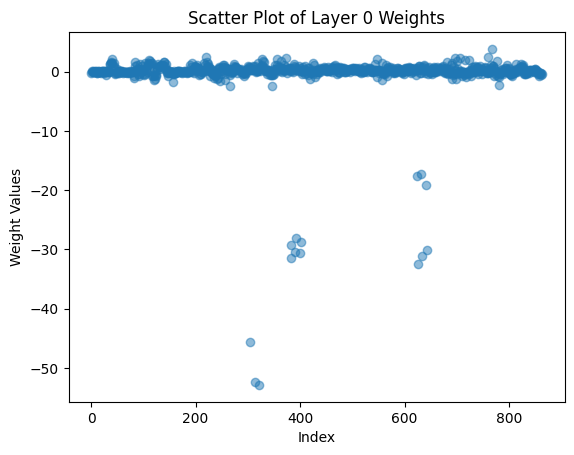

In [38]:
plt.scatter(range(len(weight_layer0.ravel())), weight_layer0.ravel(), alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Weight Values')
plt.title('Scatter Plot of Layer 0 Weights')
plt.show()

<ipython-input-36-dfd95a8f0242>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(weight_layer0.ravel())


[]

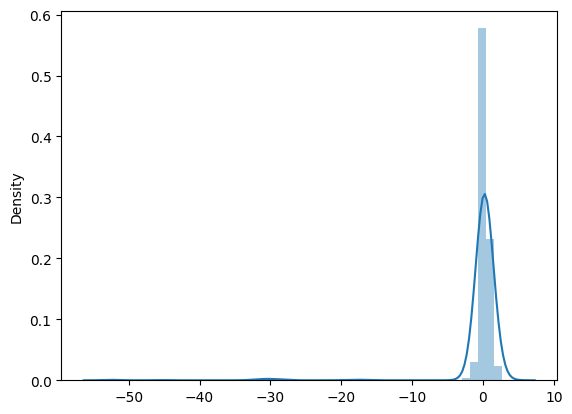

In [36]:
sns.distplot(weight_layer0.ravel())
plt.plot()

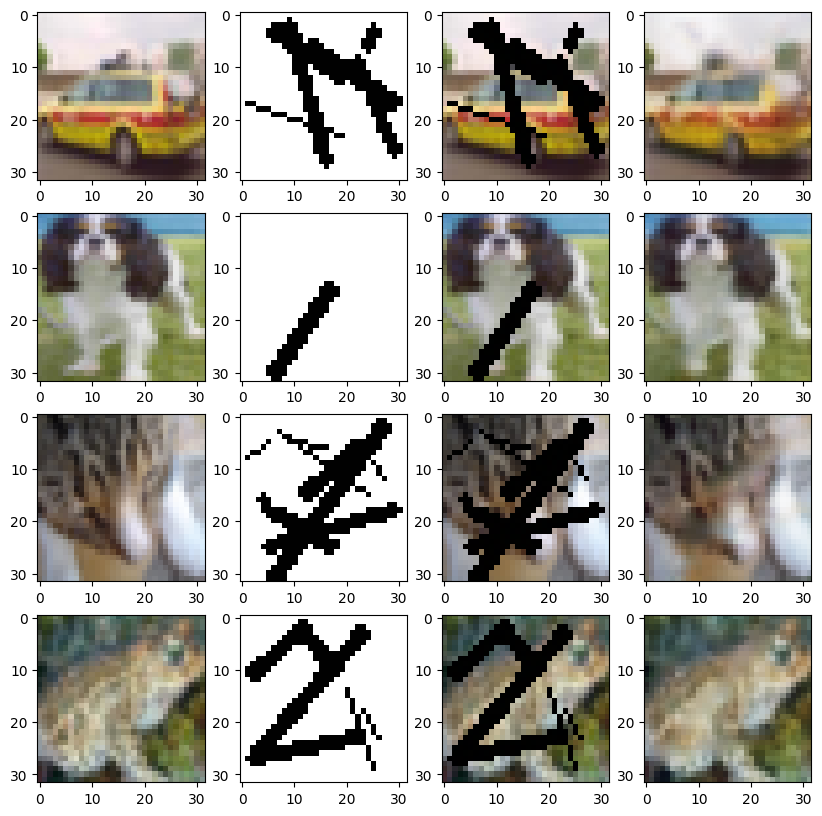

In [40]:
# visualizing the performance of the model
sample_inputs, sample_masks, sample_truths = next(Train_dataiter)

sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))